# Feedforward Neural Network Programming

## What am I doing?

Before jumping into libraries like TensorFlow or PyTorch, I'll be learning to code a feed-forward neural net from scratch with binary classification (https://en.wikipedia.org/wiki/Feedforward_neural_network)

<img src='https://upload.wikimedia.org/wikipedia/en/5/54/Feed_forward_neural_net.gif' width=50%></img>
<center>Src: Wikipedia</center>

My aims from doing this are:
* an in-depth understanding of neural nets (activation functions, vector operations)
* practicing Python
* applying mathematical knowledge learned from my fundamentals class

I will limit myself to the following libraries:
* numpy
* scipy
* math
* and other plotting functions

## Base understanding comes from:

* 3Blue1Brown's excellent series: <a href='https://www.youtube.com/watch?v=aircAruvnKk&ab_channel=3Blue1Brown'>here</a>
* sentdexs' guidance at: <a href='https://www.youtube.com/watch?v=Wo5dMEP_BbI&list=PLQVvvaa0QuDcjD5BAw2DxE6OF2tius3V3&index=1&t=37s&ab_channel=sentdex'>here</a>
* Brandon Rohrer's explanation at: <a href='https://www.youtube.com/watch?v=ILsA4nyG7I0&ab_channel=BrandonRohrer'>here</a>

...and Wikipedia!

Having already watched and read this guidance, I will try implement the code from mathematical formulas without too much other guidance. If I am using guidance, it will be referenced as such.

## Why Jupyter notebook?

So I can add markdown cells as I learn!

### Details

Let's try initially:

* 2 Inputs (1 Input for testing)
* Hidden layers (4 neurons, 2 layers, 1 bias for each layer)
* 1 output

### High Level Concept Drawing along with Feedforward matrix sizes

<img src='./ff_concept.jpg'></img>

In [1]:
# Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
%matplotlib inline

### Step 0 - Generate some dummy data to test

(admittedly, the below took a bit too long to figure out)

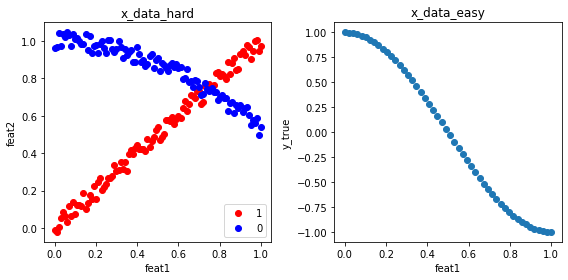

In [2]:
# To do: create data_set with obvious features

# Single Record for Testing
x_data_1 = np.random.rand(1,2) # single record with two features for testing

# Double record for Testing
x_data_2 = np.random.rand(2,2) # two records with two features for testing

# Create an easy dataset - one numerical input and one numerical output (actually a sin relationship)

x_data_easy = np.linspace(0,1) # cos relationship for testing
y_data_easy = np.cos(x_data_easy*3.14)

# Create a hard dataset - two inputs (feat1, feat2) and classification output (1, or 0). 1s have actually have a linear
# relationship between feats1 and feat2 and 0s have a cosine relationship between feat1 and feat2 with a bit of
# noise added in

x1_data_hard_1 = np.linspace(0,1,num=101,axis=0).reshape(-1,1)
x2_data_hard_1 = np.linspace(0,1,num=101,axis=0).reshape(-1,1) + np.random.default_rng().uniform(-0.05,0.05,size=(101,1))

x_data_hard_cluster1 = np.hstack((x1_data_hard_1, x2_data_hard_1))

x1_data_hard_2 = np.linspace(0,1,num=101,axis=0).reshape(-1,1)
x2_data_hard_2 = np.cos(np.linspace(0,1,num=101,axis=0).reshape(-1,1)) + np.random.default_rng().uniform(-0.05,0.05,size=(101,1))

x_data_hard_cluster2 = np.hstack((x1_data_hard_2, x2_data_hard_2))

x_data_hard = np.vstack((x_data_hard_cluster1, x_data_hard_cluster2))

y_data_hard = np.zeros(shape=(len(x_data_hard),1))
y_data_hard[:len(x_data_hard_cluster1)] = 1

# Let's have a look at just the first column of this to ensure random variables came out correctly

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].scatter(x_data_hard[:len(x_data_hard_cluster1),0], x_data_hard[:len(x_data_hard_cluster1),1], color='red',label='1')
ax[0].scatter(x_data_hard[len(x_data_hard_cluster1):,0], x_data_hard[len(x_data_hard_cluster1):,1], color='blue',label='0')
ax[0].set_title('x_data_hard')
ax[0].legend()
ax[0].set_xlabel('feat1')
ax[0].set_ylabel('feat2')
ax[1].scatter(x_data_easy, y_data_easy)
ax[1].set_title('x_data_easy')
ax[1].set_xlabel('feat1')
ax[1].set_ylabel('y_true')

fig.tight_layout()
plt.show()

### Step 1 - Activation Functions

Let's start by coding a class which holds our various activation functions, so that they can be called upon at anytime.

We will program this similar to how sklearn and other such libraries hold unique models (i.e. the ActivationFunction class will be instantiated, and the various methods will be the different activation functions)

We will take a couple popular examples from the Wiki page: https://en.wikipedia.org/wiki/Activation_function

Specifically:

* Identity: <img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/87f9e315fd7e2ba406057a97300593c4802b53e4'></img>
* Sigmoid: <img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/b2a78e39c42d7d51c4041d142740a7719e55b314'></img>
* Hyperbolic Tangent: <img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/f8e81902c8d71b06c246769bad0fe17c9cf1efd9'></img>
* ReLU: <img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/281532984565d3931de1cd1edc6e006d59fc67f4'></img>
* Softmax: <img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/3bbfe09d9d37eb94cd7a86b1bdfa24fc60e4cba5'></img>

The Softmax function does not take in a singular input unlike the other functions but rather deals with multidimensional data. As such, I have referred to the following deepai.org article which has explained it: refer <a href='https://deepai.org/machine-learning-glossary-and-terms/softmax-layer'>here</a>

In [3]:
class ActivationFunction():
    
    """The inputs to the methods of the ActivationFunction object will be x,
    ise numpy where possible as we may want to take in multiple scalars"""
    
    # Class variables
    
    def __init__(self):
        self.af_types = ['identity', 'sigmoid', 'hyperbolic_tangent', 'relu', 'softmax']
    
    def identity(self, x):
        return x
    
    def sigmoid(self, x):
        y = (1)/(1+np.exp(-x))
        return y
    
    def hyperbolic_tangent(self, x):
        x_temp = np.copy(x)
        y = (np.exp(x_temp) - np.exp(-x_temp))/(np.exp(x_temp) + np.exp(-x_temp))
        return y
    
    def relu(self, x):
        
        y = np.copy(x)
        y[y < 0] = 0
        return y
        
    def softmax(self, x_array):
        
        """Note that Softmax function takes a vector as an input and outputs a vector"""
        
        x_array = x_array.copy()
        
        y_array = np.exp(x_array)
        
        y_array_sum = np.sum(y_array, axis=1, keepdims=True)
        
        return y_array / y_array_sum    

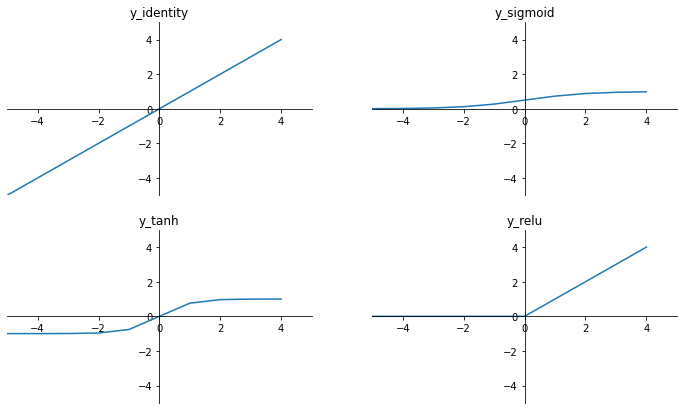

In [4]:
# Let's see if it worked

af = ActivationFunction()

# initialise some test x data
test_x = np.arange(-5,5)

# use the activation function to generate y

y_identity = af.identity(test_x)
y_sigmoid = af.sigmoid(test_x)
y_tanh = af.hyperbolic_tangent(test_x)
y_relu = af.relu(test_x)

list_all = ['y_identity', 'y_sigmoid', 'y_tanh', 'y_relu']

# plot them

fig, ax = plt.subplots(2,2,figsize=(12,7))

for i, ax in zip(list_all, ax.flat):
    
    y = globals()[i]
    
    ax.plot(test_x, y)
    ax.set_xlim(left=-5,right=5)
    ax.set_ylim(bottom=-5,top=5)
    ax.set_title(str(i))
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')


plt.show()

The above doesn't look too shabby, so the activation functions look like they're working!

### Step 2 - the Layer

Let's start by coding out a class for the Layer and give it a couple methods such as how the neurons will be calculated

Note: my initial idea was to code the <b>neuron</b> but in hindisght this made it incredibly difficult as we would have to intialise many neurons. Instead we will code a layer, which will take as a parameter the number of neurons.

<b>Feed forwarding</b> is defined as:

<img src='https://www.researchgate.net/profile/Lin-Fritschi/publication/8332488/figure/fig2/AS:601679661633573@1520463018727/Simplified-representation-of-an-individual-neuron-showing-inputs-weights-weighted-sum.png'></img>

We will also create the following functions:
* intialising random weights
* initialising random biases

In [5]:
class Dense_Layer():
    
    af = ActivationFunction()
    
    def __init__(self, input_layer, size, activation = 'relu', weights = None, biases = None, values = None, overflow_protect = False): 
        
        # activation function selection
        if activation not in af.af_types:  
            raise ValueError('Please only choose an activation function in {}'.format(af.af_types))
        else:
            self.activation = activation
           
        # check what sort of input layer it is (numpy array or Layer)
        if isinstance(input_layer, np.ndarray):
            self.input_size = input_layer.shape[1]
            self.input_values = input_layer
        elif isinstance(input_layer, Dense_Layer):
            self.input_size = len(input_layer)
            self.input_values = input_layer.values
        else:
            raise TypeError('Please ensure that input layer is an array or Layer.')
        
        self.weights = weights
        self.input_layer = input_layer
        self.size = size
        self.biases = biases
        self.overflow_protect = overflow_protect

    def randomise_weights(self):
        
        """If no weights have been pre-selected, intialise weights with random values between 0 and 1"""
        """Size expected will be (number of neurons in input * number of neurons)"""
        
        self.weights = np.random.rand(self.input_size, self.size)
        
    def randomise_biases(self):
        
        """Randomise biases"""
        """Size expected will be (1 * number of neurons)"""
        
        self.biases = np.random.rand(1, self.size)

    def feedforward(self):
        
        """Feed forward is just the dot product of the weights and inputs + the biases, which are then subject to 
        some sort of activation function"""
        
        # Ensure that weights and biases are not None
        
        if self.weights is None: self.randomise_weights()
        
        if self.biases is None: self.randomise_biases()
        
        if self.input_size == self.weights.shape[0]: # ensure that shape size of matrix multiplication is appropriate 
            
            pre_activation_vals = (np.dot(self.input_values, self.weights) + self.biases)
            
            # check if overflow protection is on, and if so, reduce pre activation vals by max
            
            if self.overflow_protect:
                
                pre_activation_vals = pre_activation_vals - np.max(pre_activation_vals, axis=1, keepdims=True)
            
            self.values = getattr(af, self.activation)(pre_activation_vals)
            
        else:
            raise ValueError('Length of weights and input array do not match!')
            
        return self.values
    
    def __len__(self):
        return self.size
    
    
    def __str__(self):
        
        np.set_printoptions(precision=2) # make sure prints okay
        
        return "=======================================\nDense Layer\n=======================================\
        \n\nWeights: \n {}\n\nBiases: \n {}\n\nValues: \n {}".format(self.weights, self.biases, self.values)
        
    

In [14]:
a = Dense_Layer(x_data_easy, size = 4,activation='relu')
a.feedforward()
b = Dense_Layer(a, size = 4, activation='relu')
b.feedforward()
c = Dense_Layer(b, size = 2, activation='softmax')
c.feedforward()
c.values

IndexError: tuple index out of range

In [18]:
x_data_easy.shape[0]

50